# OCR City Labels

Extract city names and pixel coordinates from `ttr_map.jpeg` and store them for use in `missions.ipynb`.

Output: `city_ocr.json` with entries like `{"name": "Atlanta", "x": 1234, "y": 567}`.

In [1]:
# Config
from pathlib import Path
IMAGE_PATH = Path('ttr_map.jpeg')
OUT_PATH = Path('city_ocr.json')

# Requirements: pytesseract + tesseract-ocr installed, plus pillow/opencv.
# This is a stub pipeline; fill in preprocessing + OCR steps below.

In [2]:
# Load image (Pillow)
from PIL import Image

img = Image.open(IMAGE_PATH)
# img

In [3]:
# OCR pass with tesseract availability + tessdata check
import pytesseract
import shutil
import os
from pathlib import Path

tess_path = shutil.which('tesseract')
if not tess_path:
    raise SystemExit(
        'Tesseract not found on PATH. Install it and retry. '
        'Conda: conda install -c conda-forge tesseract. '
        'Ubuntu/Debian: sudo apt-get install tesseract-ocr. '
        'macOS (brew): brew install tesseract.'
    )

# Ensure tessdata is discoverable (common issue with conda installs)
tessdata_dir = os.environ.get('TESSDATA_PREFIX')
if tessdata_dir:
    # If user points at share/, normalize to share/tessdata
    maybe = Path(tessdata_dir)
    if (maybe / 'tessdata').exists():
        tessdata_dir = str(maybe / 'tessdata')
        os.environ['TESSDATA_PREFIX'] = tessdata_dir
else:
    conda_prefix = os.environ.get('CONDA_PREFIX')
    if conda_prefix:
        candidate = Path(conda_prefix) / 'share' / 'tessdata'
        if candidate.exists():
            tessdata_dir = str(candidate)
            os.environ['TESSDATA_PREFIX'] = tessdata_dir

if not tessdata_dir:
    raise SystemExit(
        'Tesseract found but tessdata is missing. '
        'Set TESSDATA_PREFIX to the tessdata directory. '
        'Example (conda): export TESSDATA_PREFIX=$CONDA_PREFIX/share/tessdata'
    )

# Example: get OCR data with bounding boxes
data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
len(data.get('text', []))


52

In [4]:
# TODO: filter OCR results for city names; compute center points.
# Store as list of dicts: {name, x, y}
cities = []

# Example structure (replace with real data)
# cities.append({"name": "Atlanta", "x": 1234, "y": 567})

import json
OUT_PATH.write_text(json.dumps(cities, indent=2))
print(f'Wrote {OUT_PATH} with {len(cities)} entries')

Wrote city_ocr.json with 0 entries


## Handwritten OCR + Dot Detection\n
\n
This section uses EasyOCR (better for handwriting than Tesseract) and OpenCV for dot detection.\n
If EasyOCR/OpenCV aren't available, install them first.\n

In [5]:
# Optional installs (run in a terminal, not here):\n
# pip install easyocr opencv-python-headless\n
# For GPU: pip install easyocr and ensure CUDA is set up.\n

In [6]:
# EasyOCR + dot detection config
OCR_LANGS = ['en']
OCR_GPU = False
OCR_MIN_CONF = 0.35
OCR_MIN_LEN = 3
OCR_ALLOW = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz -'

PREPROCESS_OCR = True

# Dot detection thresholds (tune for your map)
DOT_HSV_LOWER = (0, 0, 0)
DOT_HSV_UPPER = (180, 255, 80)
DOT_AREA_MIN = 6
DOT_AREA_MAX = 200
DOT_R_MIN = 1.5
DOT_R_MAX = 8.0

MAX_DOT_DIST = 80.0


In [7]:
# EasyOCR text detection
import numpy as np
import json
from pathlib import Path
from PIL import Image

try:
    import easyocr
except Exception:
    raise SystemExit('EasyOCR not available. Install with: pip install easyocr opencv-python-headless')

img_pil = Image.open(IMAGE_PATH).convert('RGB')
img = np.array(img_pil)

if PREPROCESS_OCR:
    try:
        import cv2
    except Exception:
        raise SystemExit('OpenCV not available for preprocessing. Install with: pip install opencv-python-headless')
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    img_ocr = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
else:
    img_ocr = img

reader = easyocr.Reader(OCR_LANGS, gpu=OCR_GPU)
results = reader.readtext(img_ocr)
len(results)


Using CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

54

In [8]:
# Filter likely city names and compute center points for each text box
def bbox_center(bbox):
    xs = [p[0] for p in bbox]
    ys = [p[1] for p in bbox]
    return float(sum(xs) / len(xs)), float(sum(ys) / len(ys))

def clean_text(text):
    return ''.join(ch for ch in text if ch in OCR_ALLOW).strip()

cities_text = []
for bbox, text, conf in results:
    clean = clean_text(text)
    if len(clean) < OCR_MIN_LEN or conf < OCR_MIN_CONF:
        continue
    cx, cy = bbox_center(bbox)
    cities_text.append({"name": clean, "x": cx, "y": cy, "conf": float(conf)})

len(cities_text)


38

In [9]:
# Dot detection with OpenCV (adjust thresholds for dot color)
try:
    import cv2
except Exception:
    raise SystemExit('OpenCV not available. Install with: pip install opencv-python-headless')

img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(hsv, DOT_HSV_LOWER, DOT_HSV_UPPER)

# Clean mask
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
dots = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < DOT_AREA_MIN or area > DOT_AREA_MAX:
        continue
    (x, y), r = cv2.minEnclosingCircle(cnt)
    if r < DOT_R_MIN or r > DOT_R_MAX:
        continue
    dots.append({"x": float(x), "y": float(y), "r": float(r)})

len(dots)


65

In [10]:
# Naive association: nearest dot to each text label
import math

def nearest_dot(x, y, dots):
    best = None
    best_d = 1e9
    for d in dots:
        dx = d['x'] - x
        dy = d['y'] - y
        dist = math.hypot(dx, dy)
        if dist < best_d:
            best_d = dist
            best = d
    return best, best_d

cities = []
for t in cities_text:
    d, dist = nearest_dot(t['x'], t['y'], dots)
    if d is None or dist > MAX_DOT_DIST:
        continue
    cities.append({"name": t['name'], "x": d['x'], "y": d['y'], "text_x": t['x'], "text_y": t['y'], "conf": t['conf'], "dot_dist": float(dist)})

OUT_PATH.write_text(json.dumps(cities, indent=2))
print(f'Wrote {OUT_PATH} with {len(cities)} entries')


Wrote city_ocr.json with 0 entries


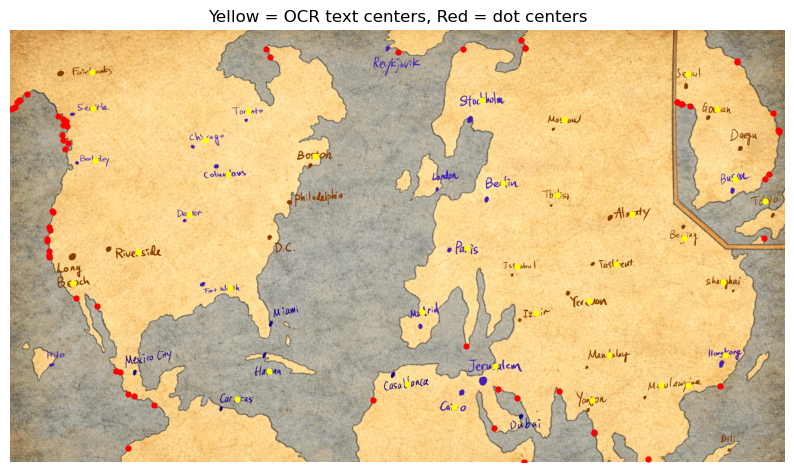

In [11]:
# Quick visualization of OCR boxes and detected dots
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(img)
for t in cities_text:
    plt.scatter(t['x'], t['y'], s=12, c='yellow')
for d in dots:
    plt.scatter(d['x'], d['y'], s=12, c='red')
plt.title('Yellow = OCR text centers, Red = dot centers')
plt.axis('off')
plt.show()


## Manual Click Fallback\n
If OCR is weak, you can click each city and type its name. This is slow but accurate.\n

In [ ]:
# Manual labeling with matplotlib (click city dots, then type names)
import matplotlib.pyplot as plt

img = np.array(Image.open(IMAGE_PATH).convert('RGB'))
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title('Click city dot locations, close window when done')
coords = plt.ginput(n=-1, timeout=0)
plt.close()

cities = []
for i, (x, y) in enumerate(coords):
    name = input(f'City name for point {i+1}: ').strip()
    if not name:
        continue
    cities.append({"name": name, "x": float(x), "y": float(y)})

OUT_PATH.write_text(json.dumps(cities, indent=2))
print(f'Wrote {OUT_PATH} with {len(cities)} entries')
